<a href="https://www.kaggle.com/code/dilekdd/iyzico-forecasting-timeseries?scriptVersionId=229904310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Iyzico is a financial technology company that simplifies the online shopping experience for both buyers and sellers. It provides payment infrastructure for e-commerce companies, marketplaces, and individual users.

The goal is to forecast the total transaction volume on a daily basis for each merchant_id during the last 3 months of 2020 (October, November, December)

## 📘 Data Dictionary

The dataset contains **4 variables** and **7,667 observations**.

| Variable Name       | Description                                                        |
|---------------------|--------------------------------------------------------------------|
| `transaction_date`  | Date of the sales transaction.                                     |
| `merchant_id`       | Unique ID for each merchant (distinct per merchant).              |
| `Total_Transaction` | Number of transactions for that merchant on the given date.       |
| `Total_Paid`        | Total payment amount received by the merchant.                    |


In [1]:
# Importing the libraries and adjusting the display settings
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import warnings
!pip install optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
# summarising the dataset
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    #print(dataframe.select_dtypes(include='number').quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)



In [3]:
########################
# Loading the data
########################

df = pd.read_csv('/kaggle/input/iyzico-payment-transaction-fraud-data/iyzico_data.csv', parse_dates=['transaction_date'])

df.head()

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,0,2018-01-01,535,349,25883.226
1,1,2018-01-01,42616,141,40918.860
2,2,2018-01-01,46774,410,306902.700
3,3,2018-01-01,86302,10,11.340
4,4,2018-01-01,124381,285,111383.766


#####################################################
# Exploratory Data Analysis
#####################################################

In [4]:
df["transaction_date"].min() # Timestamp('2018-01-01 00:00:00')


Timestamp('2018-01-01 00:00:00')

In [5]:
df["transaction_date"].max() # Timestamp('2020-12-31 00:00:00')

Timestamp('2020-12-31 00:00:00')

In [6]:
check_df(df)

##################### Shape #####################
(7667, 5)
##################### Types #####################
Unnamed: 0                    int64
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
##################### Head #####################
   Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766
##################### Tail #####################
      Unnamed: 0 transaction_date  merchant_id  Total_Transaction   Total_Paid
7662        7662       2020-12-31        46774               3394  31

In [7]:
# Removing the Unnamed column
df.drop("Unnamed: 0", axis=1,  inplace=True)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [8]:
# unique merchant_id and count of total unique merchant_id
df['merchant_id'].nunique() # 7

7

In [9]:
df['merchant_id'].unique() #Out[13]: array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

In [10]:
# Sum of Total_paid by merchant_id
df.groupby('merchant_id')['Total_Paid'].sum()

merchant_id
535       1.566015e+08
42616     3.545831e+08
46774     1.567200e+09
57192     3.173371e+08
86302     2.870447e+06
124381    1.158693e+09
129316    1.555471e+06
Name: Total_Paid, dtype: float64

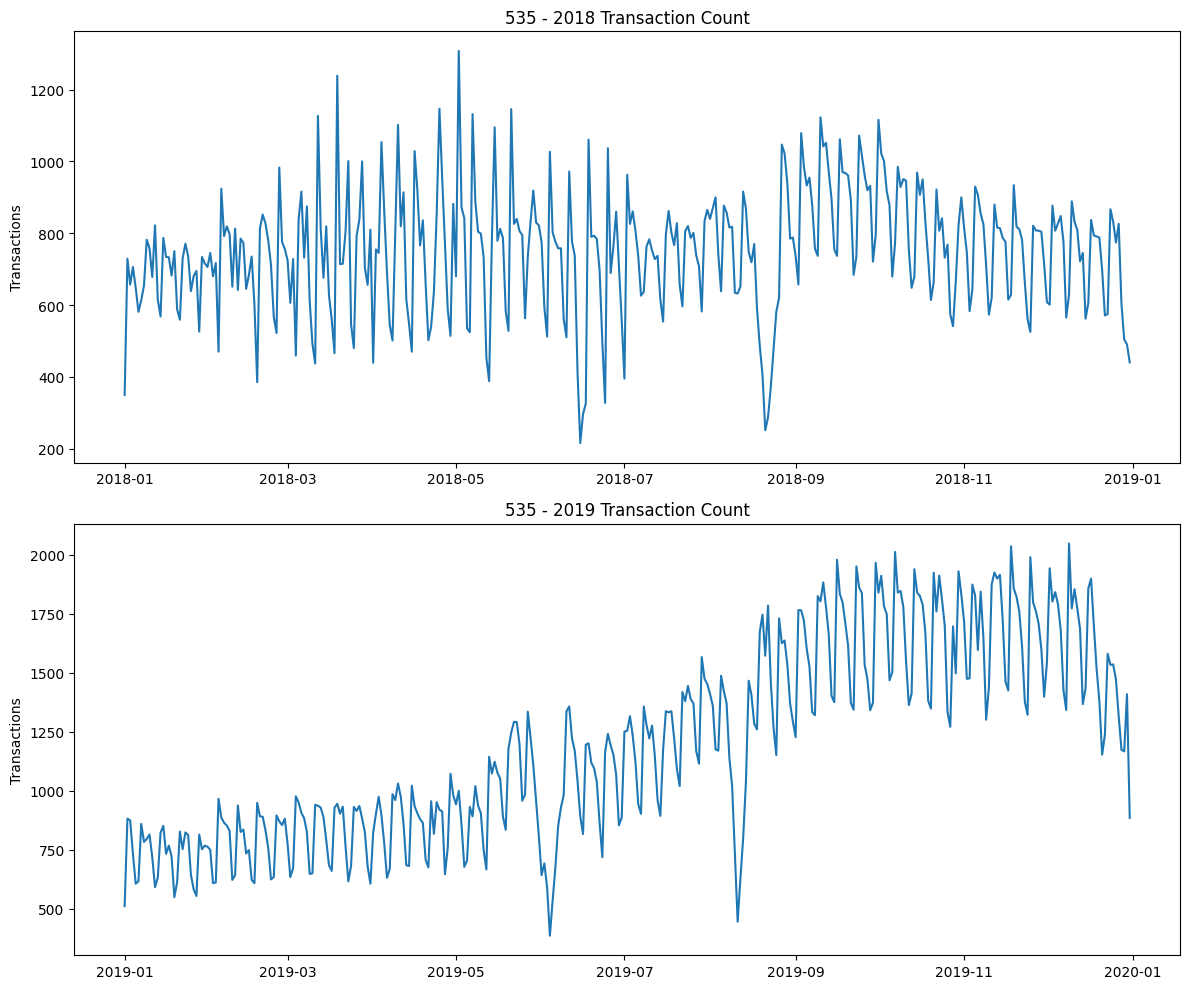

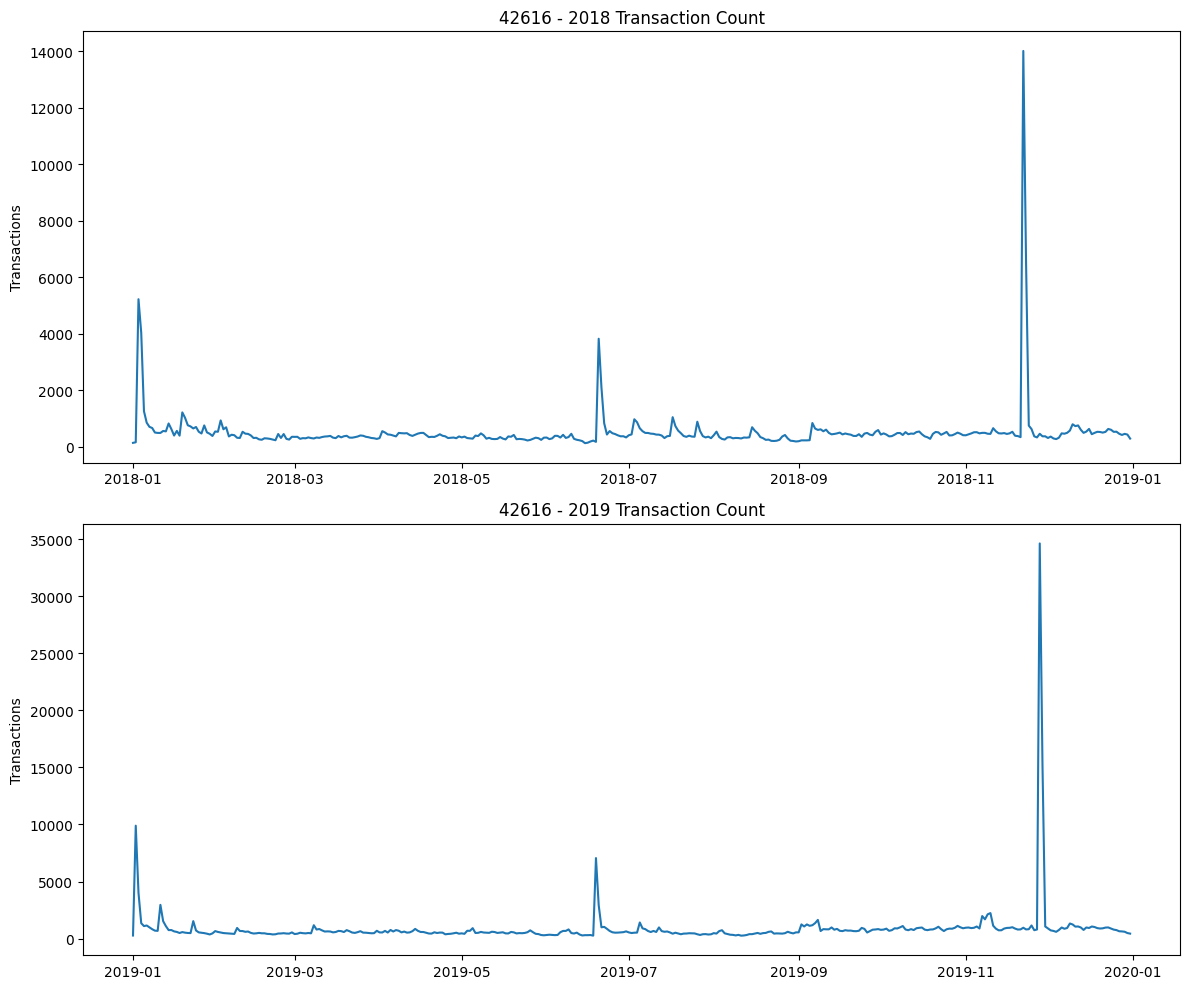

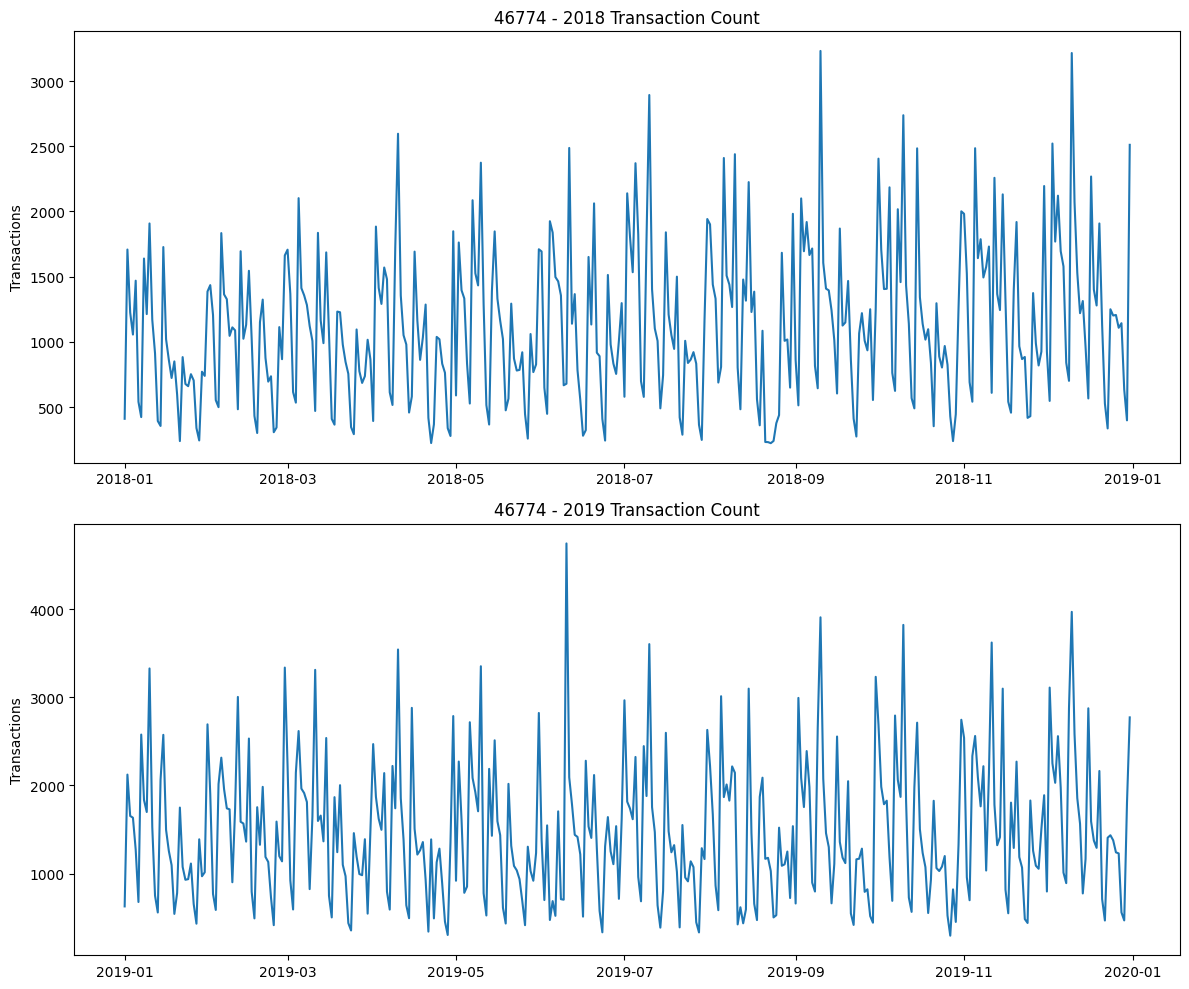

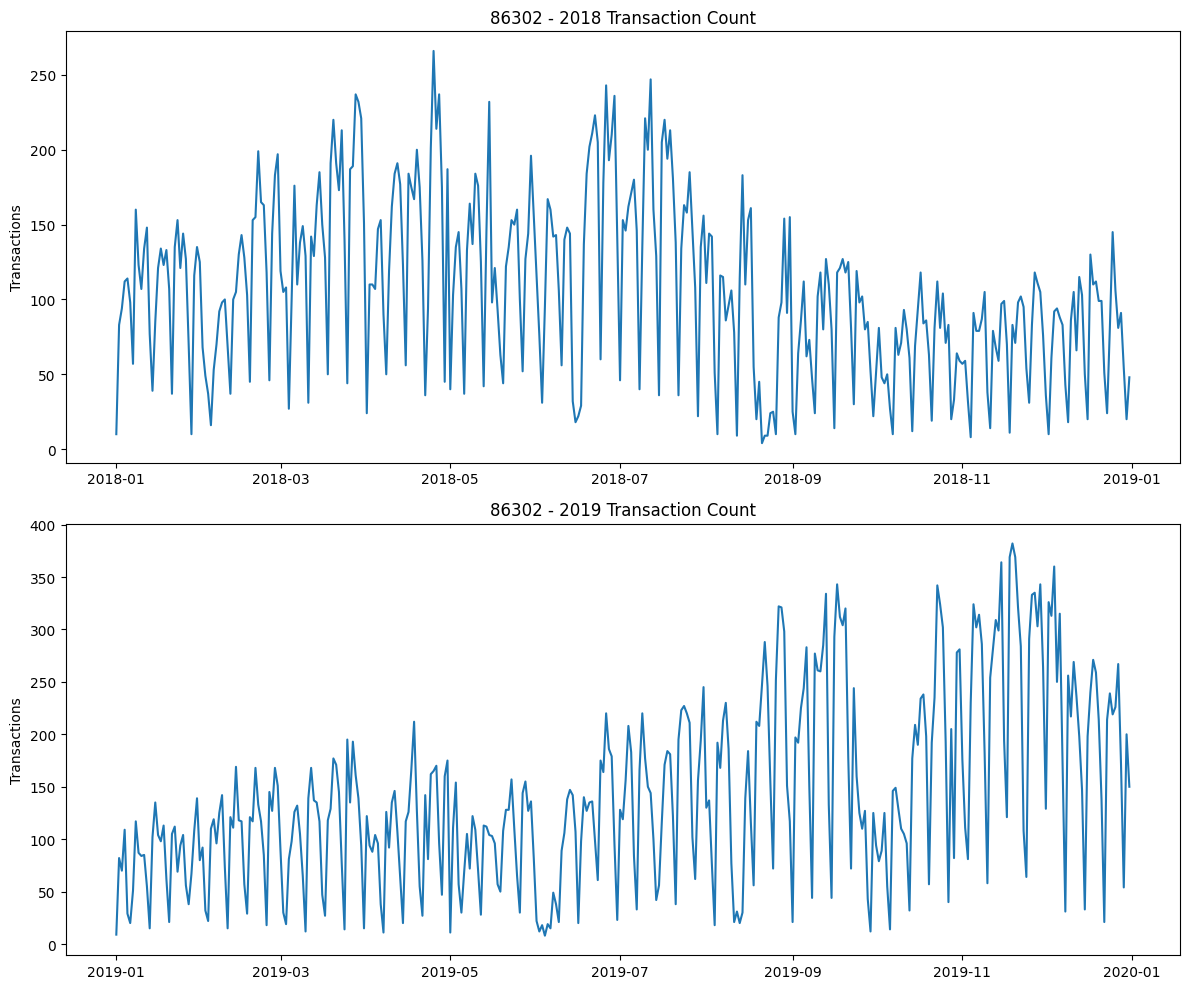

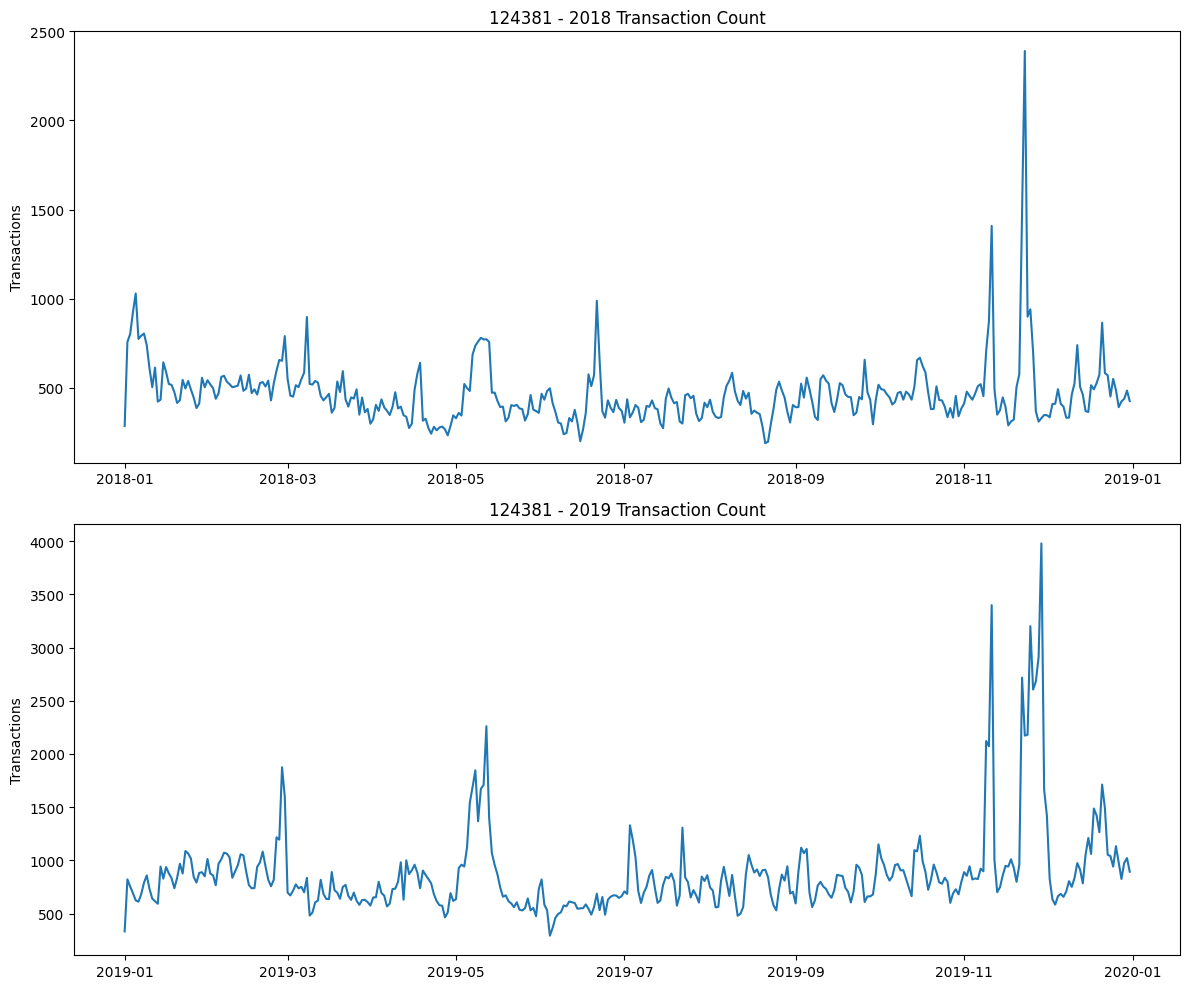

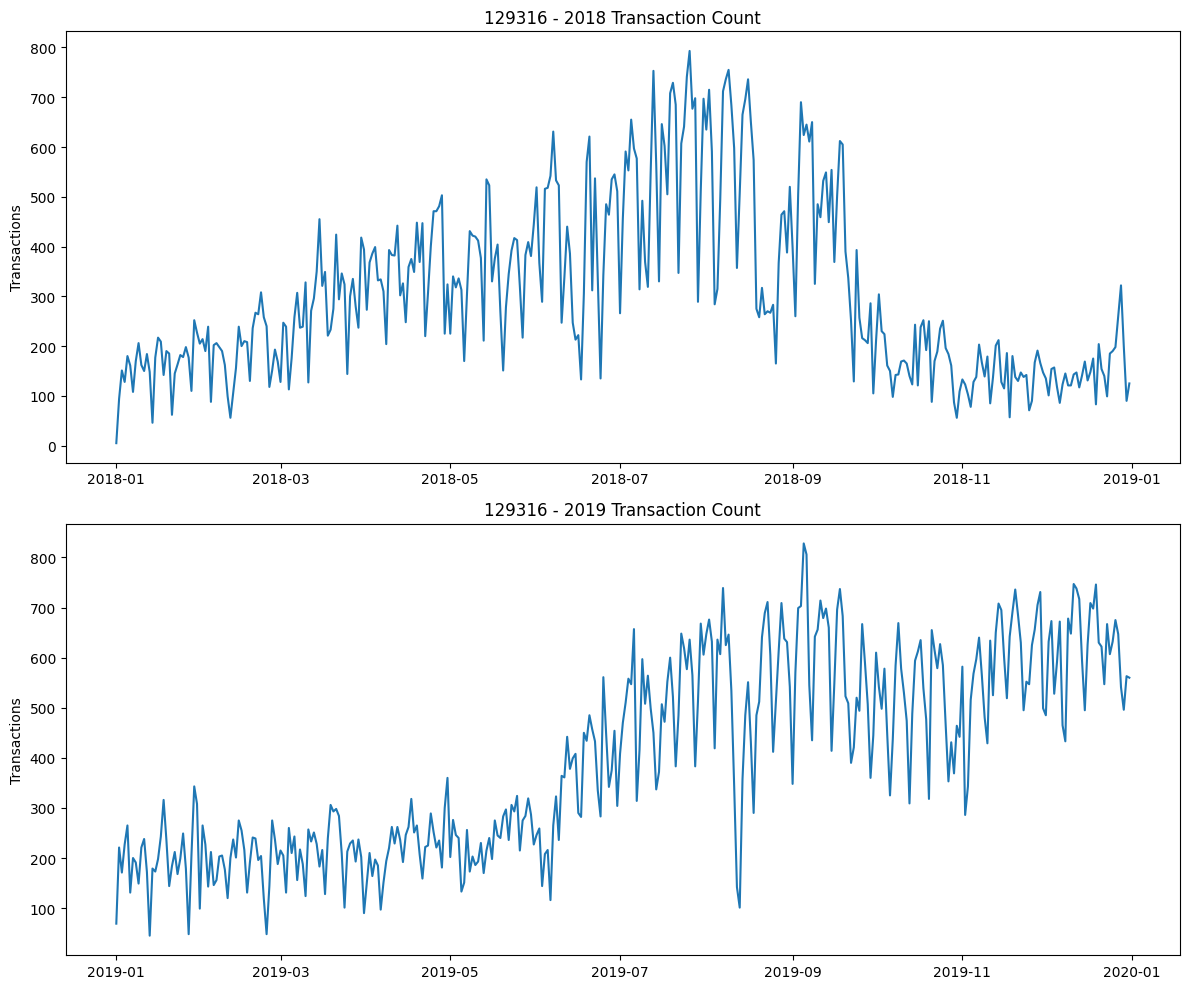

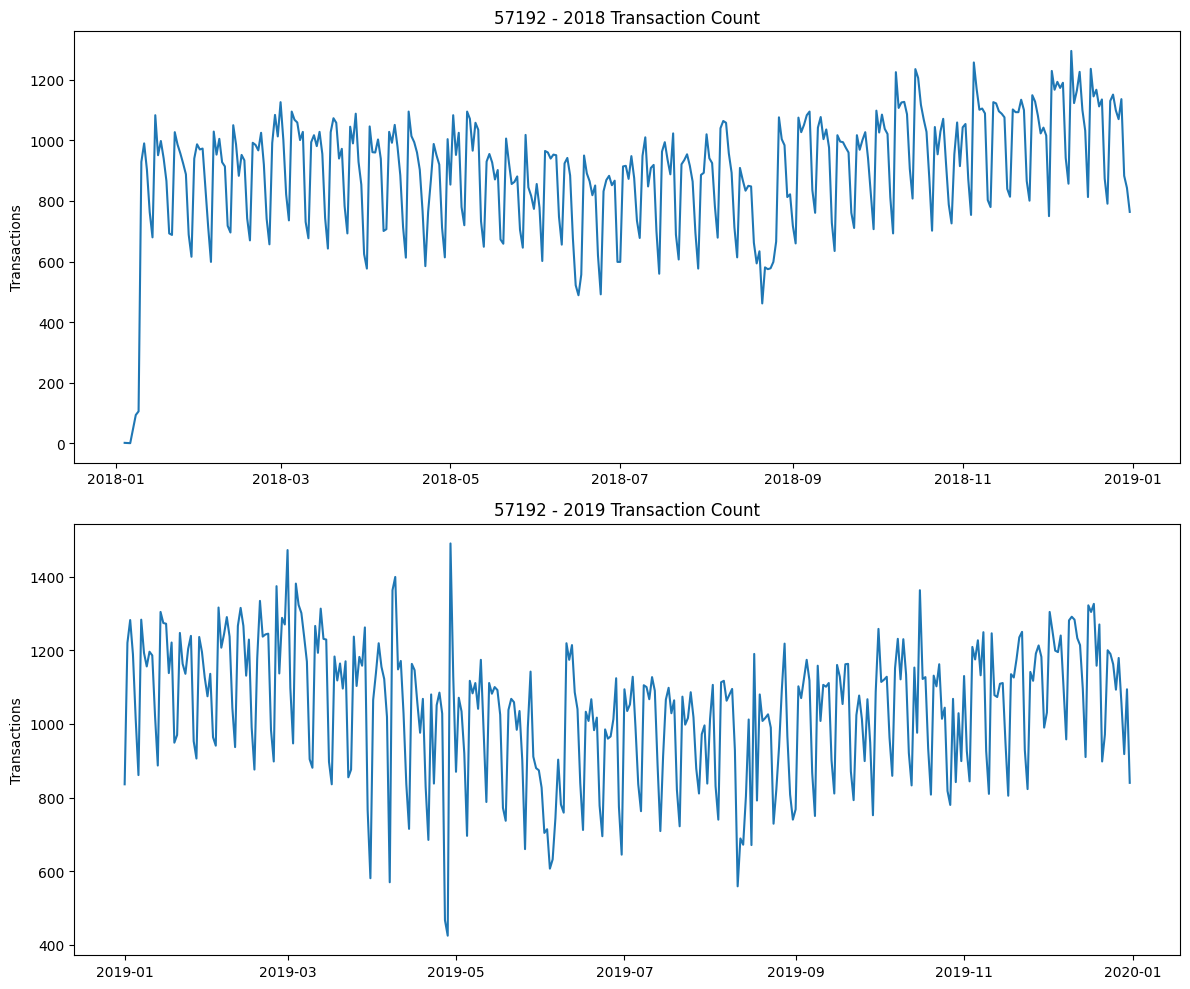

In [11]:
# Visualizes yearly transaction trends (Total_Transaction) for each merchant_id in the dataset.
def plot_transaction_trends(df, years, merchant_col='merchant_id', date_col='transaction_date', target_col='Total_Transaction'):
    for merchant in df[merchant_col].unique():
        plt.figure(figsize=(12, 5 * len(years)))
        for i, year in enumerate(years):
            plt.subplot(len(years), 1, i+1) #plt.subplot(n_rows, n_cols, plot_index)
            yearly_data = df[
                (df[merchant_col] == merchant) &
                (df[date_col] >= f"{year}-01-01") &
                (df[date_col] < f"{year+1}-01-01")
            ]
            plt.plot(yearly_data[date_col], yearly_data[target_col])
            plt.title(f"{merchant} - {year} Transaction Count")
            plt.xlabel('')
            plt.ylabel('Transactions')
        plt.tight_layout()
        plt.show()

plot_transaction_trends(df, years=[2018, 2019])


#####################################################
# FEATURE ENGINEERING
#####################################################

In [12]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df['is_wknd'] = (df[date_column].dt.weekday // 4).astype(int)
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

# Apply the function
df = create_date_features(df, "transaction_date")
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [13]:
# summary of the transaction amount of the merchants by month and year
df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({
    "Total_Transaction": ["sum", "mean", "median"]
})

Total_Transaction              
                                                  sum   mean median
merchant_id year month day_of_month                                
535         2018 1     1                          349  349.0  349.0
                       2                          729  729.0  729.0
                       3                          657  657.0  657.0
                       4                          706  706.0  706.0
                       5                          648  648.0  648.0
...                                               ...    ...    ...
129316      2020 12    27                         620  620.0  620.0
                       28                         640  640.0  640.0
                       29                         703  703.0  703.0
                       30                         642  642.0  642.0
                       31                         485  485.0  485.0

[7667 rows x 3 columns]

In [14]:
# summary of the total paid amount of the merchants by month and year
df.groupby(["merchant_id", "year", "month"]).agg({
    "Total_Paid": ["sum", "mean", "median"]
}).round(2)

Total_Paid                    
                               sum      mean    median
merchant_id year month                                
535         2018 1      2091231.81  67459.09  71088.66
                 2      2060521.06  73590.04  73345.54
                 3      2371568.27  76502.20  71045.64
                 4      2504558.75  83485.29  83215.55
                 5      2831761.17  91347.13  90838.42
...                            ...       ...       ...
129316      2020 8        72080.10   2325.16   2341.35
                 9        79788.60   2659.62   2627.55
                 10       79789.05   2573.84   2579.40
                 11       80757.45   2691.92   2704.50
                 12       87448.50   2820.92   2815.20

[252 rows x 3 columns]

#####################################################
# LAG/SHIFTED FEATURES
#####################################################

In [15]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag) + np.random.normal(scale=1.6, size=len(x))
        )
    return dataframe

df = lag_features(df, [91, 92, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
                       350, 351, 352, 352, 354, 355, 356, 357, 358, 359, 360,
                       361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
                       538, 539, 540, 541, 542,
                       718, 719, 720, 721, 722])

df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#####################################################
# WEIGHTED ROLLING MEAN
#####################################################

In [16]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()
        ) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451,
                             539, 540, 541, 629, 630, 631, 720])
df.head()

#Shifts the data by 1 day, so we're not using the current day's value (avoiding data leakage).
#rolling function takes the rolling average of defined window. Example, window=180 would mean a rolling average over the past 180 days.
# min_periods=10 allows it to calculate even if fewer than 180 past values are available.if you have at least 10 previous values,
# go ahead and calculate the average — even if it's not the full 180 yet.
# win_type="triang" means values closer to the current date get more weight in the average.
# These help your model learn seasonal trends, long-term averages, and merchant-specific behaviors.

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#####################################################
# EXPONENTIALLY WEIGHTED MOVING AVERAGE
#####################################################

In [17]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(
                    lambda x: x.shift(lag).ewm(alpha=alpha).mean()
                )
    return dataframe
# - This function takes:
#   - `dataframe`: the full dataset
#   - `alphas`: A list of smoothing factors (how much weight to give to recent vs older values)
#   - `lags`: A list of lag periods (how far back to start the moving average)
# for alpha in alphas:
#     for lag in lags:
#Loop through each combination of smoothing level (alpha) and time shift (lag)

#groupby("merchant_id"): Operate within each merchant's transaction history
# .shift(lag): Shifts the data backward by lag days to prevent data leakage (so we don't include today's value when predicting today)
# .ewm(alpha=alpha).mean(): Calculates an Exponentially Weighted Moving Average, where:
# A higher alpha (e.g., 0.95) puts more weight on recent values
# A lower alpha (e.g., 0.5) smooths more slowly, including older values more evenly


alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451, 539, 540, 541, 629, 630, 631, 720]

df = ewm_features(df, alphas, lags)
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

############################
# Black Friday - Summer Solstice
############################

In [18]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22", "2018-11-23", "2019-11-29", "2019-11-30"]), "is_black_friday"] = 1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin([
    "2018-06-19", "2018-06-20", "2018-06-21", "2018-06-22",
    "2019-06-19", "2019-06-20", "2019-06-21", "2019-06-22"
]), "is_summer_solstice"] = 1

df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

In [19]:
############# Copy of the original df ######

submission = df[df["transaction_date"] >= "2020-10-01"][["merchant_id", "transaction_date", "Total_Transaction"]].copy()
submission.head()



,merchant_id,transaction_date,Total_Transaction
7023,535,2020-10-01,2468
7024,42616,2020-10-01,942
7025,46774,2020-10-01,2897
7026,57192,2020-10-01,1240
7027,86302,2020-10-01,3070


############################
# ONE HOT ENCODING
############################

In [20]:
# Although 'merchant_id', 'day_of_week', and 'month' are represented as numerical values,
# they are actually categorical variables with no inherent order or hierarchy.
# Without encoding, machine learning models might incorrectly interpret them as ordinal features.
# To avoid this and ensure correct interpretation, we apply One-Hot Encoding (OHE),
# which creates separate binary features for each category.
df = pd.get_dummies(df, columns=['merchant_id', 'day_of_week', 'month'])


# It’s used to reduce the impact of large values and make the data more normally distributed.
# Especially helpful when the feature is right-skewed (i.e., has a long tail of large values).
# When the feature has positive values only.
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)


########################
# Custom Cost Function
########################

In [21]:
# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
# the lower the better

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


########################
# Time-Based Train / Validation Sets
########################

In [22]:
import re

df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Training set: Until October 2020
train = df.loc[df["transaction_date"] < "2020-10-01", :]

# Validation set: Last 3 months of 2020
val = df.loc[df["transaction_date"] >= "2020-10-01", :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', 'Total_Transaction', 'Total_Paid', 'year']]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

########################
# LIGHTGBM MODEL
########################

In [23]:
import optuna
from lightgbm import Dataset, train

from lightgbm import train, Dataset, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

def objective(trial):
    param_grid = {
        'metric': 'None',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    lgb_train = Dataset(X_train, label=Y_train, feature_name=cols)
    lgb_valid = Dataset(X_val, label=Y_val, reference=lgb_train, feature_name=cols)

    model = train(
        param_grid,
        lgb_train,
        valid_sets=[lgb_valid],
        num_boost_round=10000,
        feval=lgbm_smape,
        callbacks=[
            early_stopping(200),
            log_evaluation(0)  # 0 = silent, 100 = log every 100 rounds
        ]
    )

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    score = mean_absolute_error(np.expm1(Y_val), np.expm1(y_pred))

    # Print best SMAPE from LightGBM during this trial
    print(f"Trial {trial.number} - Best SMAPE from LightGBM: {round(model.best_score['valid_0']['SMAPE'], 4)}")

    trial.set_user_attr("best_smape", model.best_score['valid_0']['SMAPE'])
    trial.set_user_attr("best_iteration", model.best_iteration)

    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Getting the Best Trial
best_trial = study.best_trial

print("Best trial:")
print(study.best_trial.params)

# Retrieve the best SMAPE (from LightGBM) in that best trial
# This works only if you saved it inside the trial's user attributes during training
print(f"Best SMAPE across all trials: {round(best_trial.user_attrs['best_smape'], 4)}")

# Retrieve best iteration count
best_iteration = best_trial.user_attrs["best_iteration"]

[I 2025-03-27 00:18:56,085] A new study created in memory with name: no-name-b0b3fc3d-f789-4f59-add6-50ece9144005


Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:18:58,281] Trial 0 finished with value: 587.7852381723799 and parameters: {'learning_rate': 0.059617027890059904, 'feature_fraction': 0.7597867678407579, 'num_leaves': 50, 'max_depth': 5}. Best is trial 0 with value: 587.7852381723799.


Early stopping, best iteration is:
[109]	valid_0's SMAPE: 21.0918
Trial 0 - Best SMAPE from LightGBM: 21.0918
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:02,839] Trial 1 finished with value: 589.2798596263704 and parameters: {'learning_rate': 0.09136642195385258, 'feature_fraction': 0.47689723339744466, 'num_leaves': 79, 'max_depth': 7}. Best is trial 0 with value: 587.7852381723799.


Early stopping, best iteration is:
[177]	valid_0's SMAPE: 22.7336
Trial 1 - Best SMAPE from LightGBM: 22.7336
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:08,045] Trial 2 finished with value: 591.8079443816408 and parameters: {'learning_rate': 0.07996656835273, 'feature_fraction': 0.88245888890817, 'num_leaves': 47, 'max_depth': 10}. Best is trial 0 with value: 587.7852381723799.


Early stopping, best iteration is:
[112]	valid_0's SMAPE: 22.9116
Trial 2 - Best SMAPE from LightGBM: 22.9116
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:09,751] Trial 3 finished with value: 572.6371203482302 and parameters: {'learning_rate': 0.0458967400210814, 'feature_fraction': 0.4502539889457727, 'num_leaves': 54, 'max_depth': 5}. Best is trial 3 with value: 572.6371203482302.


Early stopping, best iteration is:
[165]	valid_0's SMAPE: 21.1309
Trial 3 - Best SMAPE from LightGBM: 21.1309
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:14,314] Trial 4 finished with value: 618.9385553924667 and parameters: {'learning_rate': 0.06252894834056036, 'feature_fraction': 0.6548492540783938, 'num_leaves': 44, 'max_depth': 8}. Best is trial 3 with value: 572.6371203482302.


Early stopping, best iteration is:
[216]	valid_0's SMAPE: 23.3482
Trial 4 - Best SMAPE from LightGBM: 23.3482
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:17,325] Trial 5 finished with value: 606.6062206788023 and parameters: {'learning_rate': 0.06090148358593035, 'feature_fraction': 0.4942662488785972, 'num_leaves': 34, 'max_depth': 7}. Best is trial 3 with value: 572.6371203482302.


Early stopping, best iteration is:
[211]	valid_0's SMAPE: 22.7677
Trial 5 - Best SMAPE from LightGBM: 22.7677
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:20,479] Trial 6 finished with value: 569.6686636753941 and parameters: {'learning_rate': 0.010666242385151927, 'feature_fraction': 0.4223342338914636, 'num_leaves': 73, 'max_depth': 4}. Best is trial 6 with value: 569.6686636753941.


Early stopping, best iteration is:
[776]	valid_0's SMAPE: 21.0145
Trial 6 - Best SMAPE from LightGBM: 21.0145
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:27,598] Trial 7 finished with value: 601.4070854355942 and parameters: {'learning_rate': 0.024884385404032937, 'feature_fraction': 0.7848055107204505, 'num_leaves': 71, 'max_depth': 7}. Best is trial 6 with value: 569.6686636753941.


Early stopping, best iteration is:
[417]	valid_0's SMAPE: 22.6066
Trial 7 - Best SMAPE from LightGBM: 22.6066
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:29,002] Trial 8 finished with value: 581.2982524902136 and parameters: {'learning_rate': 0.09470147075503767, 'feature_fraction': 0.8615235971779677, 'num_leaves': 12, 'max_depth': 4}. Best is trial 6 with value: 569.6686636753941.


Early stopping, best iteration is:
[68]	valid_0's SMAPE: 22.2109
Trial 8 - Best SMAPE from LightGBM: 22.2109
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:32,649] Trial 9 finished with value: 563.1491562611527 and parameters: {'learning_rate': 0.015062632268328172, 'feature_fraction': 0.8408616870232495, 'num_leaves': 91, 'max_depth': 4}. Best is trial 9 with value: 563.1491562611527.


Early stopping, best iteration is:
[485]	valid_0's SMAPE: 20.7364
Trial 9 - Best SMAPE from LightGBM: 20.7364
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:38,113] Trial 10 finished with value: 581.7498962145639 and parameters: {'learning_rate': 0.005029537556901437, 'feature_fraction': 0.59999101072159, 'num_leaves': 95, 'max_depth': 3}. Best is trial 9 with value: 563.1491562611527.


Early stopping, best iteration is:
[1130]	valid_0's SMAPE: 20.9839
Trial 10 - Best SMAPE from LightGBM: 20.9839
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:41,397] Trial 11 finished with value: 588.8339436215388 and parameters: {'learning_rate': 0.006555286398992308, 'feature_fraction': 0.627982024106407, 'num_leaves': 99, 'max_depth': 3}. Best is trial 9 with value: 563.1491562611527.


Early stopping, best iteration is:
[819]	valid_0's SMAPE: 21.1182
Trial 11 - Best SMAPE from LightGBM: 21.1182
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:44,351] Trial 12 finished with value: 583.5302859120133 and parameters: {'learning_rate': 0.027270143963747648, 'feature_fraction': 0.7178434954919473, 'num_leaves': 78, 'max_depth': 5}. Best is trial 9 with value: 563.1491562611527.


Early stopping, best iteration is:
[249]	valid_0's SMAPE: 21.2185
Trial 12 - Best SMAPE from LightGBM: 21.2185
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:46,215] Trial 13 finished with value: 558.4843983807527 and parameters: {'learning_rate': 0.027765484512510832, 'feature_fraction': 0.5537609774834455, 'num_leaves': 68, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[274]	valid_0's SMAPE: 20.3345
Trial 13 - Best SMAPE from LightGBM: 20.3345
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:47,937] Trial 14 finished with value: 561.2810088709521 and parameters: {'learning_rate': 0.03311634389270172, 'feature_fraction': 0.5533180020621905, 'num_leaves': 88, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[234]	valid_0's SMAPE: 20.2203
Trial 14 - Best SMAPE from LightGBM: 20.2203
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:50,778] Trial 15 finished with value: 583.8546529327165 and parameters: {'learning_rate': 0.041741367169068684, 'feature_fraction': 0.5383249045824328, 'num_leaves': 65, 'max_depth': 6}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[183]	valid_0's SMAPE: 21.2846
Trial 15 - Best SMAPE from LightGBM: 21.2846
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:57,683] Trial 16 finished with value: 580.1963358328218 and parameters: {'learning_rate': 0.03153723522634975, 'feature_fraction': 0.5535680328452716, 'num_leaves': 86, 'max_depth': 9}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[368]	valid_0's SMAPE: 21.7666
Trial 16 - Best SMAPE from LightGBM: 21.7666
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:19:59,039] Trial 17 finished with value: 569.1816381359204 and parameters: {'learning_rate': 0.036990785990209746, 'feature_fraction': 0.6780302556804729, 'num_leaves': 62, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[221]	valid_0's SMAPE: 20.6418
Trial 17 - Best SMAPE from LightGBM: 20.6418
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:03,240] Trial 18 finished with value: 581.1674245396314 and parameters: {'learning_rate': 0.020967009496062304, 'feature_fraction': 0.5645216294497585, 'num_leaves': 84, 'max_depth': 6}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[341]	valid_0's SMAPE: 21.5624
Trial 18 - Best SMAPE from LightGBM: 21.5624
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:04,657] Trial 19 finished with value: 573.9184623561667 and parameters: {'learning_rate': 0.053000618207508135, 'feature_fraction': 0.5320677204001159, 'num_leaves': 34, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[172]	valid_0's SMAPE: 21.2436
Trial 19 - Best SMAPE from LightGBM: 21.2436
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:08,122] Trial 20 finished with value: 588.8406787166666 and parameters: {'learning_rate': 0.04881624416891951, 'feature_fraction': 0.581586821678711, 'num_leaves': 62, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[127]	valid_0's SMAPE: 21.764
Trial 20 - Best SMAPE from LightGBM: 21.764
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:11,499] Trial 21 finished with value: 573.5290374326909 and parameters: {'learning_rate': 0.017720693943147008, 'feature_fraction': 0.802342687411896, 'num_leaves': 90, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[422]	valid_0's SMAPE: 21.2131
Trial 21 - Best SMAPE from LightGBM: 21.2131
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:12,757] Trial 22 finished with value: 592.7321747215105 and parameters: {'learning_rate': 0.03643895574919474, 'feature_fraction': 0.713222957081435, 'num_leaves': 90, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[129]	valid_0's SMAPE: 21.3244
Trial 22 - Best SMAPE from LightGBM: 21.3244
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:15,028] Trial 23 finished with value: 567.7906190382383 and parameters: {'learning_rate': 0.01522825535908448, 'feature_fraction': 0.4009490267331487, 'num_leaves': 100, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[505]	valid_0's SMAPE: 20.7489
Trial 23 - Best SMAPE from LightGBM: 20.7489
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:18,672] Trial 24 finished with value: 586.9840622520683 and parameters: {'learning_rate': 0.030840387001855145, 'feature_fraction': 0.6190051803443418, 'num_leaves': 80, 'max_depth': 6}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[258]	valid_0's SMAPE: 21.6172
Trial 24 - Best SMAPE from LightGBM: 21.6172
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:22,465] Trial 25 finished with value: 575.0779348509105 and parameters: {'learning_rate': 0.014640722489125388, 'feature_fraction': 0.4831583396718194, 'num_leaves': 93, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[526]	valid_0's SMAPE: 21.2672
Trial 25 - Best SMAPE from LightGBM: 21.2672
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:25,035] Trial 26 finished with value: 570.4549682125885 and parameters: {'learning_rate': 0.023556205785974352, 'feature_fraction': 0.8231334503748544, 'num_leaves': 71, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[280]	valid_0's SMAPE: 20.9601
Trial 26 - Best SMAPE from LightGBM: 20.9601
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:26,203] Trial 27 finished with value: 570.6685788072168 and parameters: {'learning_rate': 0.03323882971148634, 'feature_fraction': 0.5223435855554255, 'num_leaves': 85, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[202]	valid_0's SMAPE: 20.8778
Trial 27 - Best SMAPE from LightGBM: 20.8778
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:29,713] Trial 28 finished with value: 578.7968379718203 and parameters: {'learning_rate': 0.043132745088665464, 'feature_fraction': 0.6787298689364132, 'num_leaves': 68, 'max_depth': 6}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[227]	valid_0's SMAPE: 21.234
Trial 28 - Best SMAPE from LightGBM: 21.234
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:31,924] Trial 29 finished with value: 581.105338450569 and parameters: {'learning_rate': 0.05192822894870704, 'feature_fraction': 0.7327516955245204, 'num_leaves': 55, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[115]	valid_0's SMAPE: 20.8722
Trial 29 - Best SMAPE from LightGBM: 20.8722
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:33,354] Trial 30 finished with value: 574.3212284764952 and parameters: {'learning_rate': 0.06848903549354046, 'feature_fraction': 0.7573039196146263, 'num_leaves': 80, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[84]	valid_0's SMAPE: 21.2351
Trial 30 - Best SMAPE from LightGBM: 21.2351
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:36,003] Trial 31 finished with value: 571.4142417636355 and parameters: {'learning_rate': 0.013386142526268574, 'feature_fraction': 0.41539383891285486, 'num_leaves': 99, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[646]	valid_0's SMAPE: 21.329
Trial 31 - Best SMAPE from LightGBM: 21.329
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:40,413] Trial 32 finished with value: 571.5023047265857 and parameters: {'learning_rate': 0.019984573008460682, 'feature_fraction': 0.4587404583835791, 'num_leaves': 99, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[355]	valid_0's SMAPE: 20.7471
Trial 32 - Best SMAPE from LightGBM: 20.7471
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:42,852] Trial 33 finished with value: 568.7013363256983 and parameters: {'learning_rate': 0.010023183709948959, 'feature_fraction': 0.44690306021538806, 'num_leaves': 92, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[830]	valid_0's SMAPE: 20.4739
Trial 33 - Best SMAPE from LightGBM: 20.4739
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:20:44,550] Trial 34 finished with value: 577.9154753528466 and parameters: {'learning_rate': 0.02718479757565518, 'feature_fraction': 0.5107966961886585, 'num_leaves': 78, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[248]	valid_0's SMAPE: 21.0955
Trial 34 - Best SMAPE from LightGBM: 21.0955
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:01,457] Trial 35 finished with value: 586.9846777602252 and parameters: {'learning_rate': 0.018153934113183133, 'feature_fraction': 0.8433181621861169, 'num_leaves': 88, 'max_depth': 10}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[666]	valid_0's SMAPE: 22.5391
Trial 35 - Best SMAPE from LightGBM: 22.5391
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:03,602] Trial 36 finished with value: 585.289940111692 and parameters: {'learning_rate': 0.03985569352077252, 'feature_fraction': 0.5876196580328936, 'num_leaves': 95, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[182]	valid_0's SMAPE: 21.4856
Trial 36 - Best SMAPE from LightGBM: 21.4856
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:07,992] Trial 37 finished with value: 605.125587331291 and parameters: {'learning_rate': 0.07846267669208959, 'feature_fraction': 0.8958698966724938, 'num_leaves': 56, 'max_depth': 8}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[96]	valid_0's SMAPE: 23.8691
Trial 37 - Best SMAPE from LightGBM: 23.8691
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:11,991] Trial 38 finished with value: 569.1221105718236 and parameters: {'learning_rate': 0.013659565514399796, 'feature_fraction': 0.40715150755359353, 'num_leaves': 11, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[553]	valid_0's SMAPE: 20.7779
Trial 38 - Best SMAPE from LightGBM: 20.7779
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:13,233] Trial 39 finished with value: 591.6637905868527 and parameters: {'learning_rate': 0.02862245516448529, 'feature_fraction': 0.6608652130079158, 'num_leaves': 76, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[160]	valid_0's SMAPE: 21.2358
Trial 39 - Best SMAPE from LightGBM: 21.2358
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:17,656] Trial 40 finished with value: 579.3649288841985 and parameters: {'learning_rate': 0.010006294665392117, 'feature_fraction': 0.45958381079156335, 'num_leaves': 42, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[699]	valid_0's SMAPE: 21.189
Trial 40 - Best SMAPE from LightGBM: 21.189
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:19,726] Trial 41 finished with value: 585.8610640783501 and parameters: {'learning_rate': 0.011081893304103972, 'feature_fraction': 0.4346876693844439, 'num_leaves': 93, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[694]	valid_0's SMAPE: 20.8131
Trial 41 - Best SMAPE from LightGBM: 20.8131
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:21,237] Trial 42 finished with value: 585.6502888297125 and parameters: {'learning_rate': 0.023356490898777033, 'feature_fraction': 0.5003843520722882, 'num_leaves': 85, 'max_depth': 3}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[325]	valid_0's SMAPE: 21.4549
Trial 42 - Best SMAPE from LightGBM: 21.4549
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:25,368] Trial 43 finished with value: 567.7271990581801 and parameters: {'learning_rate': 0.00798716361459429, 'feature_fraction': 0.4396591281004909, 'num_leaves': 100, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[1055]	valid_0's SMAPE: 20.8206
Trial 43 - Best SMAPE from LightGBM: 20.8206
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:31,192] Trial 44 finished with value: 568.2603899875185 and parameters: {'learning_rate': 0.0054475541671258, 'feature_fraction': 0.47648755939182835, 'num_leaves': 99, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[1451]	valid_0's SMAPE: 21.0726
Trial 44 - Best SMAPE from LightGBM: 21.0726
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:33,423] Trial 45 finished with value: 570.4865065214954 and parameters: {'learning_rate': 0.01729227323521745, 'feature_fraction': 0.4051943940138734, 'num_leaves': 95, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[489]	valid_0's SMAPE: 21.1056
Trial 45 - Best SMAPE from LightGBM: 21.1056
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:35,880] Trial 46 finished with value: 576.8362224704542 and parameters: {'learning_rate': 0.034864156275845895, 'feature_fraction': 0.6179663528406141, 'num_leaves': 82, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[217]	valid_0's SMAPE: 21.4817
Trial 46 - Best SMAPE from LightGBM: 21.4817
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:38,019] Trial 47 finished with value: 568.7414529077379 and parameters: {'learning_rate': 0.023645490282927104, 'feature_fraction': 0.5564678515642679, 'num_leaves': 18, 'max_depth': 4}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[352]	valid_0's SMAPE: 20.9653
Trial 47 - Best SMAPE from LightGBM: 20.9653
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1106]	valid_0's SMAPE: 21.7059


[I 2025-03-27 00:21:53,019] Trial 48 finished with value: 587.8822282752301 and parameters: {'learning_rate': 0.007524981153653527, 'feature_fraction': 0.43911439675143066, 'num_leaves': 74, 'max_depth': 8}. Best is trial 13 with value: 558.4843983807527.


Trial 48 - Best SMAPE from LightGBM: 21.7059
Training until validation scores don't improve for 200 rounds


[I 2025-03-27 00:21:56,503] Trial 49 finished with value: 577.6784447548442 and parameters: {'learning_rate': 0.015163102543331631, 'feature_fraction': 0.4677119107908937, 'num_leaves': 100, 'max_depth': 5}. Best is trial 13 with value: 558.4843983807527.


Early stopping, best iteration is:
[526]	valid_0's SMAPE: 21.4088
Trial 49 - Best SMAPE from LightGBM: 21.4088
Best trial:
{'learning_rate': 0.027765484512510832, 'feature_fraction': 0.5537609774834455, 'num_leaves': 68, 'max_depth': 4}
Best SMAPE across all trials: 20.3345


In [24]:
######## FINAL MODEL WITH BEST PARAMS ########
best_params = study.best_trial.params

# Add fixed required parameters
best_params.update({
    'metric': 'None',
    'objective': 'regression',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'nthread': -1
})

lgb_train_full = lgb.Dataset(X_train, label=Y_train, feature_name=cols)

final_model = train(
    best_params,
    lgb_train_full,
    num_boost_round=best_iteration,
    feval=lgbm_smape,
    callbacks=[log_evaluation(100)]
)


########################
# FEATURE IMPORTANCE
########################

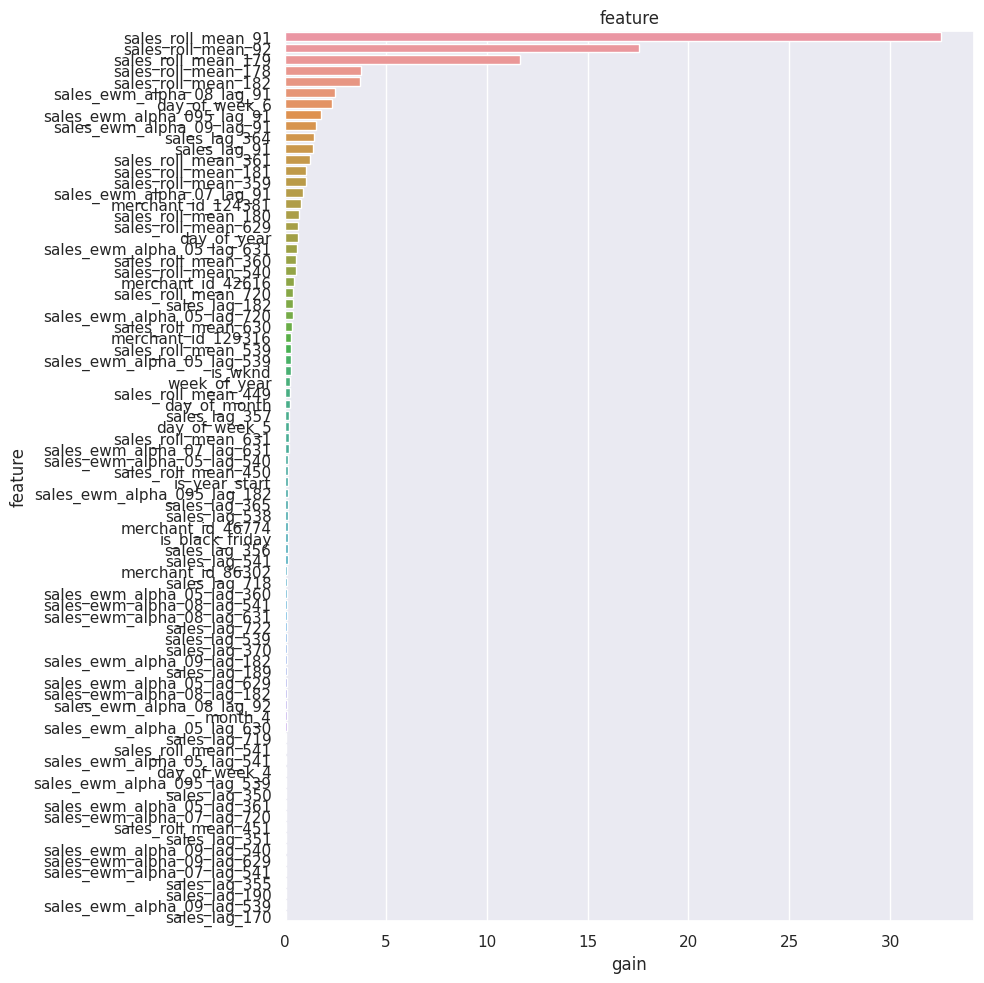

,feature,split,gain
64,sales_roll_mean_91,225,32.519786
65,sales_roll_mean_92,113,17.543761
67,sales_roll_mean_179,54,11.664330
66,sales_roll_mean_178,52,3.767940
70,sales_roll_mean_182,38,3.703732
...,...,...,...
116,sales_ewm_alpha_09_lag_451,0,0.000000
126,sales_ewm_alpha_08_lag_178,0,0.000000
127,sales_ewm_alpha_08_lag_179,0,0.000000
136,sales_ewm_alpha_08_lag_451,0,0.000000


In [25]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:num])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(final_model, num=80, plot=True)

In [26]:
feat_imp = plot_lgb_importances(final_model, num=212)
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats), len(feat_imp)

                        feature  split       gain
64           sales_roll_mean_91    225  32.519786
65           sales_roll_mean_92    113  17.543761
67          sales_roll_mean_179     54  11.664330
66          sales_roll_mean_178     52   3.767940
70          sales_roll_mean_182     38   3.703732
..                          ...    ...        ...
116  sales_ewm_alpha_09_lag_451      0   0.000000
126  sales_ewm_alpha_08_lag_178      0   0.000000
127  sales_ewm_alpha_08_lag_179      0   0.000000
136  sales_ewm_alpha_08_lag_451      0   0.000000
106  sales_ewm_alpha_09_lag_178      0   0.000000

[212 rows x 3 columns]


(190, 212)

########################
# FINAL MODEL
########################

In [27]:
train = df[df["transaction_date"] < "2020-10-01"]
Y_train = train["Total_Transaction"]
X_train = train[imp_feats]

test = df[df["transaction_date"] >= "2020-10-01"]
X_test = test[imp_feats]

final_params = study.best_trial.params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'None',     # because you're using custom feval (SMAPE)
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'nthread': -1
})


# Create LightGBM dataset
lgb_final = lgb.Dataset(data=X_train, label=Y_train, feature_name=imp_feats)

# Train the final LightGBM model (no early stopping or validation at this stage)
final_model = lgb.train(
    params=final_params,
    train_set=lgb_final,
    num_boost_round=1000)

# these are not the real sales amounts, we applied log transformation
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)


test_preds = np.expm1(test_preds)  # Reversing log1p 
test_preds.shape


(644,)

########################
# FINAL PREDICTIONS
########################

In [28]:
test.head()

submission["Total_Transaction_Pred"] = test_preds  # test_preds must be same length as this df

submission.to_csv("Iyzico_submission.csv", index=False)

submission.head()

,merchant_id,transaction_date,Total_Transaction,Total_Transaction_Pred
7023,535,2020-10-01,2468,2306.804405
7024,42616,2020-10-01,942,964.188134
7025,46774,2020-10-01,2897,2673.989328
7026,57192,2020-10-01,1240,1198.359791
7027,86302,2020-10-01,3070,3038.351033
